# The Normalized Cross Correlation Coefficient

In this section we summarize some basic properties of the normalized cross correlation coefficient (NCC).
This will be useful for the quantification of image similarity and for statistical tests of signifance based the observed values of the NCC.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import numpy.ma as ma

from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.integrate import trapz, simps

from skimage.io import imread
from aloe.plots import plot_image

from PIL import Image

# for fitting probability densities to a normal distribution
def gauss(x,a,x0,sigma):
    """
    gaussian function for input x values
    with amplitude=a, mean=x0, stddev=sigma 
    """
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


# seed the random number generator so the randomness below is repeatable
#np.random.seed(1234)

## Definition

A description of various useful interpretations of the correlation coefficient is given by Rodgers and Nicewander in ["Thirteeen Ways to Look at the Correlation Coefficent"](http://dx.doi.org/10.1080/00031305.1988.10475524). 
An extensive treatment of the statistical use of correlation coefficients is given in [D.C. Howell, "Statistical Methods for Psychology"](http://www.worldcat.org/oclc/913018446).

The [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), or normalized cross correlation coeffcient (NCC) is defined as:

$r =\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}$

This can also be written as: 

$r = r_{xy} = \sum ^n _{i=1} \frac{1}{\sqrt{n-1}} \left( \frac{x_i - \bar{x}}{s_x} \right) \cdot \frac{1}{\sqrt{n-1}} \left( \frac{y_i - \bar{y}}{s_y} \right)$

sample mean: $\bar{x}=\frac{1}{n}\sum_{i=1}^n x_i$ 

The normalization to $(n-1)$ degrees of freedom in the alternative form of $r$ above is related to a corresponding definition of the sample standard deviation $s$: 
$s_x=\sqrt{\frac{1}{n-1}\sum_{i=1}^n(x_i-\bar{x})^2}$ 

Notes:

* The numerical calculation of the standard deviation in Numpy can use $n-0$ or $n-1$, which is controlled by the parameter ddof=0/1.
https://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html
_The average squared deviation is normally calculated as x.sum() / N, where N = len(x). If, however, ddof is specified, the divisor N - ddof is used instead._

* To check the correct implementation, the NCC of a sample with itself needs to return 1.0 



In [2]:
def norm_data(data):
    """
    normalize data to have mean=0 and standard_deviation=1
    """
    mean_data=np.mean(data)
    std_data=np.std(data, ddof=1)
    #return (data-mean_data)/(std_data*np.sqrt(data.size-1))
    return (data-mean_data)/(std_data)
    

def ncc(data0, data1):
    """ 
    normalized cross-correlation coefficient between two data sets
    
    Parameters:
    -----------
    data0, data1 :  numpy arrays of same size
    """
    return (1.0/(data0.size-1)) * np.sum(norm_data(data0)*norm_data(data1))

## Simple Example

We will use U and V as the names for the random variables in this initial example (to avoid confusion with x and y in a two-dimensional plot, i.e. U and V are both independent variables or observations).

### Initialize Some Random Data

U_true:
[-2.45467033 -1.98958959 -2.18882951 -2.28434502 -2.17318062  0.93545043
 -1.23684526 -1.62600276  2.87656306  2.07570175  1.20893602 -2.49329479
  1.28785335 -0.80492425  1.82110054  0.29842003 -0.45845943  0.01946024
  0.65032618 -1.98040671 -2.20417686 -0.57581176  0.69035706  2.65371224
 -1.66427092 -0.06824372 -2.20862938 -1.32400137 -2.00919442  1.93490166
 -1.66090731  2.85520804  0.24795768  1.54138588 -1.17591262 -1.31285414
  1.67112717 -2.83689366  0.60643827  0.13791804  0.56264742 -2.89160413
 -2.00892642 -0.05266171 -1.72910945 -2.55219006 -0.46544907  0.24705298
 -0.40473084  2.81795365]
V_true:
[  2.32692308   3.62914915   3.07127737   2.80383393   3.11509425
  11.8192612    5.73683326   4.64719227  17.25437657  15.0119649
  12.58502084   2.21877459  12.80598938   6.9462121   14.29908151
  10.03557607   7.91631358   9.25448867  11.02091331   3.65486123
   3.02830479   7.58772707  11.13299978  16.63039426   4.54004143
   9.0089176    3.01583774   5.49279617   3.5

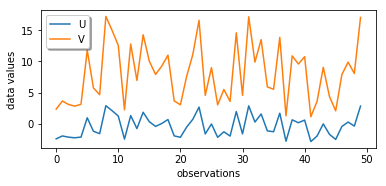

In [3]:
ndata=50
U_true= 3 *(-1.0 + 2.0*np.random.rand(ndata)) # vary between -3 and 3
print('U_true:')
print(U_true)
V_true=2.8*U_true+9.2 # V depends linearly on the *random* U
print('V_true:')
print(V_true)
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
ax.plot(U_true, label='U')
ax.plot(V_true, label='V')
ax.legend(loc='upper left', shadow=True, fancybox=True)
ax.set_ylabel('data values')
ax.set_xlabel('observations')
plt.show()

Although each of the line plots by itself looks rather random, when we compare U and V, we see that V is rising when U is rising and V is falling when U is falling, just with a different amplitude and with an underlying offset. A high/low value in the U data set *correlates with* a high/low value in the V data set. 

### Correlation Plot

To see the relationship between U and V, we plot U as a function of V. Note the use of a scatter plot instead of a line plot; we just like to see the relationship between the related data *points*. 

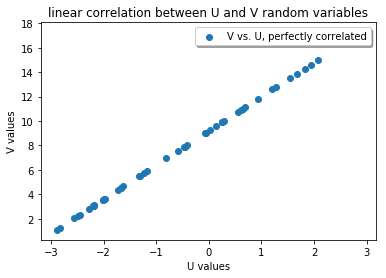

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(U_true,V_true, label= "V vs. U, perfectly correlated")
ax.legend(loc='upper right', shadow=True, fancybox=True)
ax.set_ylabel('V values')
ax.set_xlabel('U values')
ax.set_title('linear correlation between U and V random variables')
plt.show()

As we see above, if U has a specific observed random value, V has a completely determined value, which does not depend on the position of the observation in the U and V data set, the order of the observation of the (U,V) pairs does not matter. In the plot that would mean that the lower values of U could have been observed before the higher values of U; in fact, any order of observations would still create the line that we see.  
In this way, the line that we see is just a result of this perfect correlation, for non-perfect correlation, this plot will look different, as we will see below. 

The NCC is 1.0 for these two data sets, indicating that apart from scaling and offset, they are "similar".
Note that the NCC is symmetric, i.e. exchanging the data sets does not change the NCC:

In [5]:
ncc1=ncc(U_true,V_true)
print(ncc1)
ncc1_rev=ncc(V_true,U_true)
print(ncc1_rev)

1.0
1.0


Now we add additional random variations on both  U and V and see how the NCC changes.

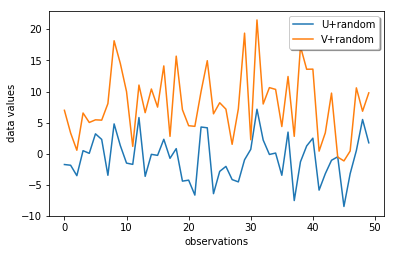

In [6]:
stddev=3.0
U_exp = U_true + np.random.normal(scale=stddev,size=ndata)
V_exp = V_true + np.random.normal(scale=stddev,size=ndata)


fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
ax.plot(U_exp, label='U+random')
ax.plot(V_exp, label='V+random')
ax.legend(loc='upper right', shadow=True, fancybox=True)
ax.set_ylabel('data values')
ax.set_xlabel('observations')
plt.show()

Now we check the correlation between the U and V data with random errors, and we see that we don not have a nice line anymore!

0.608263515004


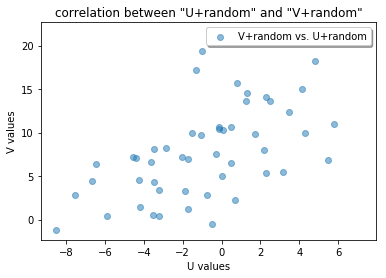

In [7]:
ncc2=ncc(U_exp,V_exp)
print(ncc2)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(U_exp,V_exp, alpha=0.5, label= "V+random vs. U+random")
ax.legend(loc='upper right', shadow=True, fancybox=True)
ax.set_ylabel('V values')
ax.set_xlabel('U values')
ax.set_title('correlation between "U+random" and "V+random"')
plt.show()

## Statistical Distribution of the Cross Correlation Coefficient

We now compare the distribution of the NCC values for a large set of experiments (y) with the theory (x).  So x and y correspond to U and V in the simple example above.

We can start by looking at the result of totally random data in x and y, where the different NCCs should be distributed around zero. 

Note: Try to set the "stddev" value below to different values and observe what happens if x and y become increasingly spread. The surprising result is that the spread of the NCC histogram does _not_ change with the standard deviation of the distribution of the actual values in the x and y data sets!  Then what determines the shape of this curve? The answer will follow below...

In [8]:
def get_correlated_samples(nsamples=50, r=0.5, means=[1,1], stddevs= [1.0, 1.0]):
    """
    get two correlated random data sets
    """
    sd = np.diag(stddevs) # SD in a diagonal matrix
    observations = np.random.normal(0, 1, (2, nsamples)) 

    cor_matrix = np.array([[1.0, r],
                           [r, 1.0]]) # correlation matrix [2 x 2]

    cov_matrix = np.dot(sd, np.dot(cor_matrix, sd)) # covariance matrix

    Chol = np.linalg.cholesky(cov_matrix) # Cholesky decomposition
    sam_eq_mean = Chol.dot(observations)  # Generating random MVN (0, cov_matrix)

    s = sam_eq_mean.transpose() + means  # adding the means column wise
    samples = s.transpose()              # Transposing back
    return samples


def get_r_sample(nruns=1000, nsamples=50, r=0.5,
                 means=[0, 0], stddevs=[1.0, 1.0]):
    """ get correlated x,y datasets with defined correlation r """
    samples=np.zeros(nruns)
    for i in range(nruns):
        x,y = get_correlated_samples(nsamples=nsamples, r=r, 
                                     means=means, stddevs=stddevs)
        samples[i]=ncc(x,y)
    return samples


def get_ncc_sample_r0(nruns=1000,stddev=1.0):
    """
    get ncc samples from population with correlation=0
    """
    samples=np.zeros(nruns)
    for i in range(nruns):
        x = np.random.normal(scale=stddev,size=ndata)
        y = np.random.normal(scale=stddev,size=ndata)
        samples[i]=ncc(x,y)
    return samples

We will first plot a histogram for a range of trials where we create two datasets of ndata points and calculate their NCC. The NCC will not be constant, as our data sets are random. The NCC can be different from zero in the specific trials, as we can have accidentally correlated values for a dataset of limited size, i.e. there is some chance for three random values to be correlated with NCC=0.1 to three other random values. We expect that the variation of the NCC values around zero will become sharper for  larger data sets, i.e. there is a much smaller chance for 100 random values to show NCC=0.1 to 100 other random values.

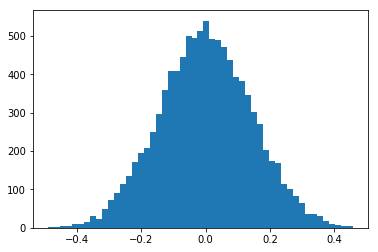

In [9]:
nruns=10000
stddev=37.0
ncc_samples=np.zeros(nruns)
for i in range(nruns):
    x = np.random.normal(scale=stddev,size=ndata)
    y = np.random.normal(scale=stddev,size=ndata)
    ncc_samples[i]=ncc(x,y)

counts, binval, _ = plt.hist(ncc_samples,bins=51)

Now we compare experiments for the same underlying true x and y data (taken from the U and V data sets above), however with two different amounts of randomness in the experimental x and y. Because of the correlation between x and y, the NCC distribution is centered around a nonzero value and  the distribution histogram of the NCC becomes _asymmetric_ relative to the most probable NCC value. 


First, we add Gaussian noise with stddev=10.0 to the true, perfectly correlated values, and the NCC values will decrease any vary asymmetrically around about 0.4:

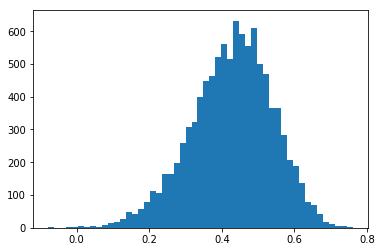

In [10]:
nruns=10000
stddev=10.0

x_true = U_true
y_true = V_true

ncc_samples=np.zeros(nruns)
for i in range(nruns):
    x = x_true 
    y = y_true + np.random.normal(scale=stddev,size=ndata)
    ncc_samples[i]=ncc(x,y)

counts, binval, _= plt.hist(ncc_samples,bins=51)

With less random noise (stddev=2.0) on the true, perfectly correlated values, the most probable NCC moves nearer to 1.0:

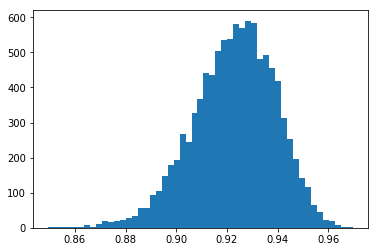

In [11]:
nruns=10000
stddev=2.0 

ncc_samples=np.zeros(nruns)
for i in range(nruns):
    x2 = x_true
    y2 = y_true + np.random.normal(scale=stddev,size=ndata)
    ncc_samples[i]=ncc(x2,y2)

counts, binval, _= plt.hist(ncc_samples,bins=51)

With even less noise, stddev=0.2, the NCC values approach 1.0.
Note that the NCC still varies, but it can never be larger than 1.0.

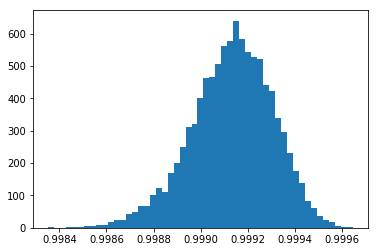

In [12]:
nruns=10000
stddev=0.2 

ncc_samples=np.zeros(nruns)
for i in range(nruns):
    x2 = x_true
    y2 = y_true + np.random.normal(scale=stddev,size=ndata)
    ncc_samples[i]=ncc(x2,y2)

counts, binval, _= plt.hist(ncc_samples,bins=51)

### Degrees Of Freedom: 

We check what happens to the distribution of NCC values when we repeat some values in the x and y data sets.

In [13]:
nruns=10000
stddev=50.0

# sample size 5 times of original data, all random
# ~ 5 times more dof
ncc_samples=np.zeros(nruns)
for i in range(nruns):
    x = np.random.normal(scale=stddev,size=5*ndata)
    y = np.random.normal(scale=stddev,size=5*ndata)
    ncc_samples[i]=ncc(x,y)
    
# repeat 5 samples of ndata    
ncc_samples5=np.zeros(nruns)
for i in range(nruns):
    x = np.random.normal(scale=stddev,size=ndata)
    y = np.random.normal(scale=stddev,size=ndata)
    x=np.ravel([x,x,x,x,x])
    y=np.ravel([y,y,y,y,y])
    ncc_samples5[i]=ncc(x,y)    

# compare to result for original sample size/dof
ncc_samples1=np.zeros(nruns)
for i in range(nruns):
    x = np.random.normal(scale=stddev,size=ndata)
    y = np.random.normal(scale=stddev,size=ndata)
    ncc_samples1[i]=ncc(x,y)        

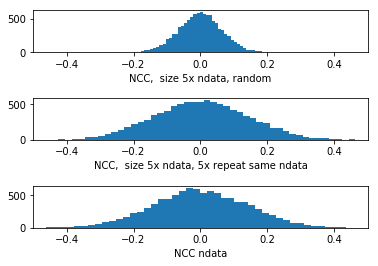

In [14]:
fig = plt.figure()
plt.subplots_adjust(hspace = 1.1)
ax = fig.add_subplot(311)    
counts, binval, _ = plt.hist(ncc_samples,bins=51)
ax.set_xlim(-0.5,0.5)
ax.set_xlabel('NCC,  size 5x ndata, random')

ax = fig.add_subplot(312)    
counts, binval, _ = plt.hist(ncc_samples5,bins=51)
ax.set_xlim(-0.5,0.5)
ax.set_xlabel('NCC,  size 5x ndata, 5x repeat same ndata')

ax = fig.add_subplot(313)   
counts, binval, _ = plt.hist(ncc_samples1,bins=51)
ax.set_xlim(-0.5,0.5)
ax.set_xlabel('NCC ndata')

plt.show()

The variation of ncc_samples5 (middle) is the same as that of the initial set with size ndata (bottom), while a data set with  $5\times$ndata truly random data points shows a reduced variation in the distribution of the NCC values.
We cannot reduce the variation of the NCC by simply repeating some values.

Since in our data set of $5\times$ repeated ndata samples, not all observations are independent, the sample size in this case is __NOT__ equivalent to the degrees of freedom in the data set. From the plots above, we would expect that, compared to $5\times$ ndata, the effective sample size should be ndata, as this gives the same distribution as our $5\times$ repeated ndata points. 

The correlation in the $5\times$ repeated ndata points reduces the effective sample size, which is signaled by the increased width of the NCC curve around zero, compared to $5\times$ndata independent random values.

Will this observation enable us to define at least an *effective* sample size (DOF) via the distribution of the NCC? (WIP)

### Standard Deviation and Degrees Of Freedom for Zero Correlation

Fit to Model for NCC distribution around $r=0$:

In [15]:
ncc0=get_ncc_sample_r0(nruns=10000, stddev=0.7)

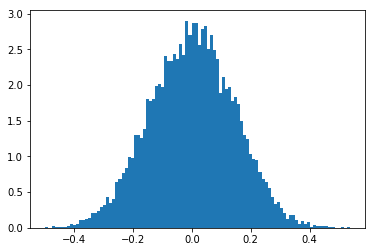

In [16]:
ax = plt.subplot(111) 
counts, binval, patches = plt.hist(ncc0,bins=100, density=True)

In [17]:
zmean,zstd=norm.fit(ncc0)
print(zmean,zstd)
dof0=2+(1.0/zstd)*(1.0/zstd)
print(dof0)
print(ndata)
print('?!')

0.0010341137774 0.142702017499
51.1065895793
50
?!


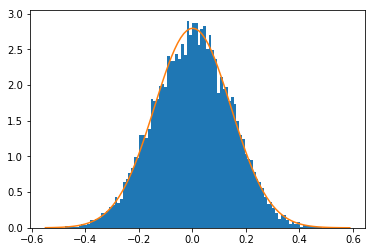

In [18]:
plt.hist(ncc0, bins=100, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, zmean, zstd)
plt.plot(x, y)
plt.show()

For __uncorrelated__ data sets (mean value of NCC is 0), we can extract the initial degrees of freedom (the independent data points $N$) from the standard deviation $\sigma$ of a normal distribution fitted to the histogram of the NCC values (see Howell):

$\sigma_r= \frac{ 1 }{ \sqrt{N-2} }$ 

Given only the histogram above, we can estimate the ndata=50 defined for the random data sets at the beginning of this chapter.
In addition, note that this result does not depend on the standard deviation or mean of the uncorrelated data sets, which seems a little like magic, doesn't it?

Can we also achieve something similar when the data is correlated, i.e. the mean NCC is $r>0$? It turns out that this is possible after transforming the NCC $r$ values so that they become distributed normally also for $r>0$, as will be discussed next.

### Z transformation

Fisher (1921) has shown that one can convert the NCC $r$ to a value $z$ that is approximately normal distributed (see Howell, Chapter 9, "Correlation and Regression"). The calculation of $z$ will enable us to compare the variation of the NCC at *different* levels of the NCC, e.g. we can answer questions like "Is the correlation between two data sets significantly different from the correlation between a second pair of data sets" (where the data sets can have a different number of observations etc and thus a different statistical variation of the NCC values).


$z= 0.5\cdot\ln\frac{|1+r|}{|1-r|}$

In [19]:
def z_transform(r):
    """
    Fisher's z transform for the correlation coefficient
    """
    return 0.5*np.log((1.0+r)/(1.0-r))

In [20]:
ncc1 = get_r_sample(nruns=10000, r=0.9, stddevs=[0.1,200])
z1=z_transform(ncc1)
ncc2 = get_r_sample(nruns=10000, r=0.2, stddevs=[3,17])
z2=z_transform(ncc2)

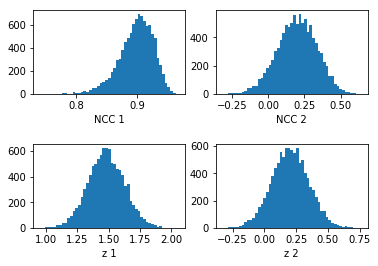

In [21]:
fig = plt.figure()
plt.subplots_adjust(hspace = 0.6)

ax = fig.add_subplot(221)
counts, binval, _= ax.hist(ncc1,bins=51, density=False)
#ax.set_xlim(-0.5,0.8)
ax.set_xlabel('NCC 1')

ax = fig.add_subplot(222) 
counts, binval, _= ax.hist(ncc2,bins=51, density=False)
#ax.set_xlim(-0.5,0.8)
ax.set_xlabel('NCC 2')

ax = fig.add_subplot(223) 
counts, binval, _= ax.hist(z1,bins=51, density=False)
#ax.set_xlim(0.49,0.8)
ax.set_xlabel('z 1')

ax = fig.add_subplot(224) 
counts, binval, _= ax.hist(z2,bins=51, density=False)
#ax.set_xlim(0.49,0.8)
ax.set_xlabel('z 2')
plt.show()

Note, in the plots above, the noise can be different between upper and lower rows because of the different binning of the NCC $r$ values vs. $z$-transformed values.

### Estimation of DOF from correlated data

The Degrees Of Freedom $N$ for non-zero correlation can be estimated from the standard deviation of the z-transformed NCC values. For __correlated__ data sets (mean value of NCC <> 0), $z$ is approximately normally distributed  with standard error $\sigma_z$ (see Howell, Chapter 9, "Correlation and Regression"):

$\sigma_z= \frac{ 1 }{ \sqrt{N-3} }$ 

Like in the case of zero correlation, we can try to recover the initial Degrees of Freedom from the standard deviation of $z$ as:

$N=\frac{1}{\sigma_z^2}+3$

In [22]:
def get_DOF_from_zstd(zstd):
    return 3+(1.0/zstd)**2

zmean1,zstd1=norm.fit(z1)
print('z1 mean, std:', zmean1,zstd1)
dof1=get_DOF_from_zstd(zstd1)
print('DOF1 from sigma:', dof1)

zmean2,zstd2=norm.fit(z2)
print('z2 mean, std:', zmean2,zstd2)
dof2=get_DOF_from_zstd(zstd2)
print('DOF2 from sigma:', dof2)

z1 mean, std: 1.48250889198 0.145913970571
DOF1 from sigma: 49.9684522319
z2 mean, std: 0.204039241315 0.145911239076
DOF2 from sigma: 49.9702107704


For our independent random data points with defined correlation , we nicely obtain values near 50, the initial ndata, for arbitrary mean and standard deviation in the two data sets! Statistical magic again...

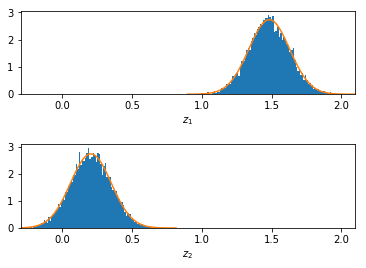

In [23]:
fig=plt.figure()
plt.subplots_adjust(hspace = 0.6)
ax = fig.add_subplot(211) 
ax.hist(z1, bins=100, density=True)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, zmean1, zstd1)
ax.plot(x, y)
ax.set_xlabel('$z_1$')
ax.set_xlim([-0.3, 2.1])


ax = fig.add_subplot(212) 
ax.hist(z2, bins=100, density=True)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, zmean2, zstd2)
ax.plot(x, y)
ax.set_xlabel('$z_2$')
ax.set_xlim([-0.3, 2.1])
plt.show()

In the two plots above, we can see that the $z$-transformation nicely scales the distributions to have the same standard deviation (which is determined by the DOF), even with strongly different values of the correlation coefficients. As the standard deviations are the same, we obtain the same estimate for ndata.

## Example Data: Kikuchi Pattern Fits

We now look at an example for the distribution of the values of the NCC for a range of different "experiments". 
An "experiment" will correspond to the intensity values in an image that was flattened to a 1D array.
The example data is from an EBSD measurement for a large number (16752) of different Kikuchi patterns (200x142 = 28400 pixels = length of 1D array data set like in U or V above). The aim was to discriminate between two different possible "theories", which show a slightly different NCC when compared to a single experimental pattern. 

For the 16752 pattern fits, a different NCC value is obtained relative to both theories ($r_0$, $r_1$), and we have to decide which of the two theories is the better fit and possibly give a confidence level for this discrimination.

In [24]:
mtxt=np.loadtxt(fname='./data/K2C_0802_200x142.MTXT',skiprows=1)
print(mtxt.shape)

(16752, 17)


In [25]:
r0=mtxt[:,15]
r1=mtxt[:,16]

z0=z_transform(r0)
z1=z_transform(r1)

#save
zxc0=z0
zxc1=z1

In [26]:
zmean0,zstd0=norm.fit(z0)
print(zmean0,zstd0)
    
dof0=get_DOF_from_zstd(zstd0)
print(dof0)

zmean1,zstd1=norm.fit(z1)
print(zmean1,zstd1)
dof1=get_DOF_from_zstd(zstd1)
print(dof1)

0.570489403049 0.0255338370613
1536.79682559
0.554417278644 0.0242830681437
1698.87127012


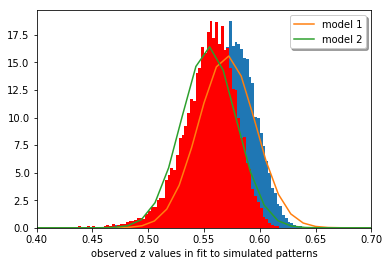

In [27]:
counts0, bin_edges0, bars0 =  plt.hist(z0, bins=400, 
                                range=[0.0, 1.0], density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, zmean0, zstd0)
plt.plot(x, y, label = 'model 1')

counts1, bin_edges1, bars1 = plt.hist(z1, bins=400,  
                       range=[0.0, 1.0], density=True,color='r')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, zmean1, zstd1)
plt.plot(x, y, label = 'model 2')
plt.xlim(0.4,0.7)
plt.xlabel('observed z values in fit to simulated patterns')
plt.legend(loc='upper right', shadow=True, fancybox=True)
plt.show()

#### Alternative description of the statistical distribution: Gaussian peak fitting

Instead of using the mean and standard deviation as estimators, we can also use a peak fit to the distribution of NCC values.

area under curve:  1.0
17.9391630044 0.557906573021 -0.0218208750639
DOF:  2103.17591921
area under curve:  1.0
17.0039312638 0.574155051808 -0.0230554070979
DOF:  1884.28420725


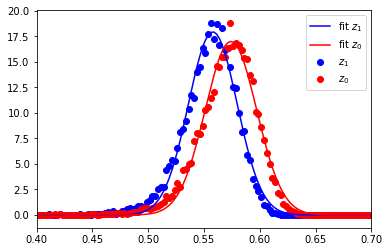

In [28]:
z1= 0.5*(bin_edges1[1:] + bin_edges1[:-1])
print('area under curve: ',trapz(counts1, z1))

popt,pcov = curve_fit(gauss,z1,counts1,p0=[np.max(counts1),np.mean(z1),1.0])

a_fit, mean_fit, sigma_fit = popt
print(a_fit, mean_fit, sigma_fit)
dofdz=get_DOF_from_zstd(sigma_fit)
print('DOF: ',dofdz)

plt.scatter(z1,counts1,label='$z_1$',color='b')
plt.plot(z1,gauss(z1,*popt),'b',label='fit $z_1$')


z0= 0.5*(bin_edges0[1:] + bin_edges0[:-1])
print('area under curve: ',trapz(counts0, z0))

popt,pcov = curve_fit(gauss,z0,counts0,p0=[np.max(counts0),np.mean(z0),1.0])

a_fit, mean_fit, sigma_fit = popt
print(a_fit, mean_fit, sigma_fit)
dofdz=3+(1.0/sigma_fit)**2
print('DOF: ',dofdz)

plt.scatter(z0,counts0,label='$z_0$',color='r')
plt.plot(z1,gauss(z0,*popt),'r',label='fit $z_0$')
#plt.xlim(0.75,0.87)
plt.xlim(0.4,0.7)
plt.legend()
plt.show()

From the standard deviation of the distribution of the NCC values, we would naively estimate the effective DOF to be in the range of 2000 for the patterns of 200x142=28400 pixels. 

In a test scenario, we could assume the null hypothesis that both NCCs are equal, and thus test for the difference to be zero.

The overlap of the curves does not mean that we actually have data points (patterns) where the _difference_ in $z$ is zero. This is because the values in both curves are strongly correlated, i.e. if we have a value in the high end of the tail of th $z_0$ curve, the corresponding $z_1$ value will be in the high end tail of the $z_1$ curve, i.e. not in the low end which would be required to make the difference $z_1 - z_0$ zero.

To see the correlation effect, we additionally analyze the distribution of the _differences_ of the z-transformed r values: 

area under curve:  1.0
152.893245084 0.0161660677057 0.00258786986515
DOF:  74662.5103872


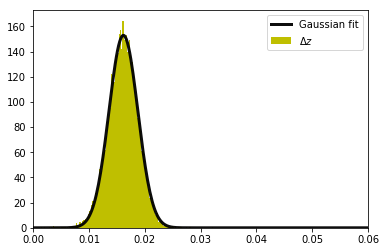

In [29]:
dz=np.abs(zxc1-zxc0)
counts, bin_edges, bars = plt.hist(dz, bins=500, range=[0.0, 0.1], 
                        density=True, color='y',label='$\Delta z$')

z = 0.5*(bin_edges[1:] + bin_edges[:-1])
zc=counts
print('area under curve: ',trapz(zc, z))

popt,pcov = curve_fit(gauss,z,zc,p0=[np.max(zc),np.mean(z),1.0])

a_fit, mean_fit, sigma_fit = popt
print(a_fit, mean_fit, np.abs(sigma_fit))
dofdz=3+(1.0/(np.sqrt(2)*sigma_fit))**2
print('DOF: ',dofdz)

#plt.scatter(z,zc,label='$\Delta z$', color='y')
plt.plot(z,gauss(z,*popt),'k',label='Gaussian fit', 
         lw=3.0, alpha=0.95)
plt.xlim(0.0,0.06)
plt.legend()
plt.show()

The estimated DOF from the z difference is unrealistically too large because the two distributions from which the z difference was obtained are not independent. 
Thus we _cannot_ simply apply $\sigma_{diff}^2 = \sigma_0^2 + \sigma_1^2 = 2\sigma_m^2$ to estimate the mean sigma $\sigma_m$ of the initial from the distribution of the differences  $\sigma_{diff}$. The sigma of the z difference is much smaller than expected for independent random $z_0$ and $z_1$.

If we *assume* that the fitted plot above is the true frequency distribution, clearly all or almost all experimentally observed values are away from 0.0, which would allow us to reject the null hypothesis at the 99.9...% level.

The problem is that we do not know the theoretical distribution beforehand, because our data points (image pixel intensities) are not independent and we do not know the "effective DOF" in a specific Kikuchi pattern. Otherwise we can estimate the theoretical distribution of the NCC values and also their difference from the DOF, like shown above. Once an estimation for the effective DOF in a Kikuchi pattern is avalaible, the usual testing scenarios are straightforward. 

Since we compare the same experimental pattern with two theories that are also correlated, the change in NCC between the two comparison is smaller than would be expected for two independent theoretical patterns (i.e. the two theoretical patterns look very similar also). 

To be mathematically correct, the "spatial" correlation between the image pixels, as well as the mutual correlation of the simulated theory-patterns need to be included somehow in the test scenario. We can know the correlation between the theoretical patterns, but we also have to estimate the spatial correlation in each of the theoretical patterns. (Hoteling, Schneider, see D.C. Howell, "Statistical Methods for Psychology").

## Application as an Image Similarity Measure

The NCC (a.k.a. Pearson correlation coefficient, $r$) has several useful properties for the quantitative comparison of EBSD patterns.

* normalized patterns on well defined scale (mean=0.0 and standard deviation=1.0)
* inversion of contrast is trivial: multiply the normalized pattern by -1


A number of similarity and dissimilarity measures for images are discussed, for example, in [A. Goshtasby "Image Registration" (Springer, 2012)](http://www.springer.com/de/book/9781447124573), who summarizes the question of choosing a similarity/dissimilarity measure for photographic images (p.57):

> Each similarity/dissimilarity measure has its strengths and weaknesses. A measure
that performs well on one type of images may perform poorly on another type of images. Therefore, an absolute conclusion cannot be reached about the superiority of one measure against another. 
However, the experimental results obtained on various image types and various image differences reveal that Pearson correlation coefficient, Tanimoto measure, minimum ratio, L$_1$ norm, square L$_2$ norm, and intensity ratio variance overall perform better than other measures. If the images are captured under different exposures of a camera or under different lighting of a scene,
the results show that Pearson correlation coefficient, Tanimoto measure, normalized
square L$_2$ norm, and incremental sign distance perform better than others.



The __Normalized Inner Product__ (NIP), which is not discusssed in the text above, has also been used as a similarity measure for pattern matching and indexing of EBSD and ECP, see:

* [1] Y.H. Chen et al., *A Dictionary Approach to Electron Backscatter Diffraction Indexing*, [Microscopy and Microanalysis 21 (2015) 739](https://doi.org/10.1017/S1431927615000756)

* [2] S. Singh, M. De Graef, *Dictionary Indexing of Electron Channeling Patterns.* [Microscopy and Microanalysis 23 (2017) 1](https://doi.org/ 10.1017/S1431927616012769)

* [3] S. Singh, F. Ram and M. De Graef , *Application of forward models to crystal orientation refinement*,  [J. Appl. Cryst. (2017) 50](https://doi.org/10.1107/S1600576717014200)


 


In the following, we will demonstrate some key differences between the NCC and the NIP, which is defined according to [1] as:

$\rho =\frac{ \langle \mathbf{X} , \mathbf{Y} \rangle}{||\mathbf{X}|| \cdot ||\mathbf{Y}||}$

with ${\langle \mathbf{X} , \mathbf{Y} \rangle}$ being the dot product (inner product) of the image vectors $\mathbf{X}$ and $\mathbf{Y}$.

Note that, compared to the NCC, the NIP does neither involve the removal of the mean from the image nor does it involve a normalization according to the image "energy" (standard deviation = 1.0). These features will make the NIP much less useful as an image similarity measure when images are compared which vary in intensity and mean level. 

In [30]:
def norm_dot(img1, img2):
    """
    return normalized dot product of the arrays img1, img2
    """
    # make 1D value lists
    v1 = np.ravel(img1)
    v2 = np.ravel(img2)
    
    # get the norms of the vectors
    norm1=np.linalg.norm(v1)
    norm2=np.linalg.norm(v2)
    #print('norms of NDP vectors: ', norm1, norm2)

    ndot=np.dot( v1/norm1, v2/norm2)
    return ndot

To get a feeling for the typical relative values for a low-noise experimental image and a suffciently good simulation, we compare the NCC and the NIP of the same two images:

In [31]:
def print_similarity_measures(img1, img2, nc0=None, nd0=None):
    nd = norm_dot(img1, img2)
    nc = ncc(img1, img2)
    print('NCC: ', nc, ' NDP: ', nd)
    if not ((nc0 is None) or (nd0 is None)): 
        print('dNCC: ', nc-nc0, ' dNDP: ', nd-nd0)
    return 

(240, 320) float64


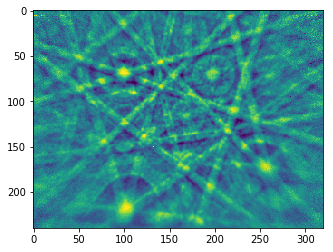

(240, 320) float64


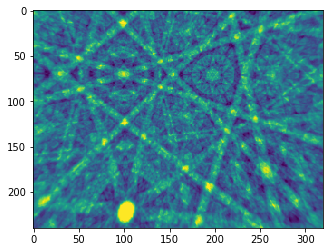

In [32]:
img_exp = np.array(Image.open('./data/ocean_grain_final.png').convert(mode='L'), dtype=np.float64)
print(img_exp.shape, img_exp.dtype)
plt.figure()
plt.imshow(img_exp)
plt.show()

img_sim = np.array(Image.open('./data/ocean_dynsim.png').convert(mode='L'), dtype=np.float64)
print(img_sim.shape, img_sim.dtype)
plt.figure()
plt.imshow(img_sim)
plt.show()

We obtain a NCC near 0.7, which usually indicates a very good fit; the relevant NIP is 0.966 for the two loaded images:

In [33]:
# initial images
test_exp = img_exp
test_sim = img_sim
ndot_0 = norm_dot(test_exp, test_sim)
ncc_0  = ncc(test_exp,test_sim)
print('NCC: ', ncc_0)
print('NIP: ', ndot_0)

NCC:  0.693403929513
NIP:  0.96608536923


In [34]:
# scale both: the ncc and ndp stay at their initial values
test_exp = 2.0*img_exp
test_sim = 2.0*img_sim
print_similarity_measures(test_exp, test_sim)

NCC:  0.693403929513  NDP:  0.96608536923


In [35]:
# scale both differently: the ncc and ndp stay at their initial values
test_exp = 2.0*img_exp
test_sim = 5.0*img_sim
print_similarity_measures(test_exp, test_sim)

NCC:  0.693403929513  NDP:  0.96608536923


In [36]:
# offset 
test_exp = img_exp+100
test_sim = img_sim+100
print_similarity_measures(test_exp, test_sim)

NCC:  0.693403929513  NDP:  0.990367125922


An offset which is large enough will drive the NDP towards 1.0, because the relative variations in the image vector length due to the image intensity variations will become neglible:

In [37]:
test_exp = img_exp+100000
test_sim = img_sim+100000
print_similarity_measures(test_exp, test_sim)

NCC:  0.693403929513  NDP:  0.999999957916


In [38]:
test_exp = img_exp-100
test_sim = img_sim
print_similarity_measures(test_exp, test_sim)

NCC:  0.693403929513  NDP:  0.622125967693


In [39]:
test_exp = img_exp
test_sim = img_sim-1000
print_similarity_measures(test_exp, test_sim)

NCC:  0.693403929513  NDP:  -0.947714913572


In [40]:
test_exp = -1.0*img_exp+8000
test_sim = -1.0*img_sim-1000
print_similarity_measures(test_exp, test_sim)

NCC:  0.693403929513  NDP:  -0.999271034085


### Random Images

For checking the beaviour under totally random imges, we create images with random float values from 0 to 1 and then calculate the NCC and NIP.

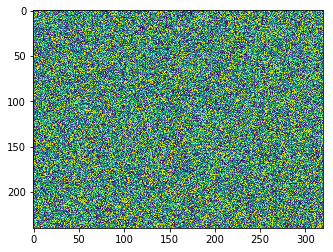

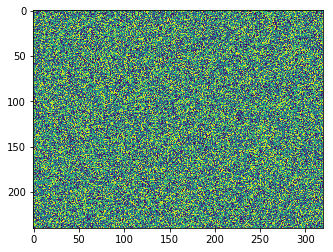

In [41]:
# random images
img1_random = np.random.rand(img_exp.shape[0], img_exp.shape[1])
img2_random = np.random.rand(img_exp.shape[0], img_exp.shape[1])

plt.figure()
plt.imshow(img1_random)
plt.show()

plt.figure()
plt.imshow(img2_random)
plt.show()

In [42]:
nruns=1000

def compare_random_images(nruns, offset=0.0, scale=1.0):
    nc_list=np.zeros(nruns, dtype=np.float32)
    nd_list=np.zeros(nruns, dtype=np.float32)
    for i in range(nruns):
        # 0..1 float random numbers
        img1_random = np.random.rand(img_exp.shape[0], img_exp.shape[1])
        img2_random = np.random.rand(img_exp.shape[0], img_exp.shape[1])

        # note: difference for images 0..1 values as compared -1,1
        test_exp =  offset + scale * img1_random
        test_sim =  offset + scale * img2_random

        nc_list[i] = ncc(test_exp, test_sim)
        nd_list[i] = norm_dot(test_exp, test_sim)
    return nc_list, nd_list

nc_vals, nd_vals = compare_random_images(nruns)

When normalizing each image with 8bit intensities from 0..255 (or 0..65535 for 16bit), the resulting (random) unit image vectors reside only in one quadrant of the high-dimensional sphere so we obtain a value of 3/4 for the expection value of the NDP, not zero like for the NCC.

see, e.g. a discussion here:
https://math.stackexchange.com/questions/2422001/expected-dot-product-of-two-random-vectors

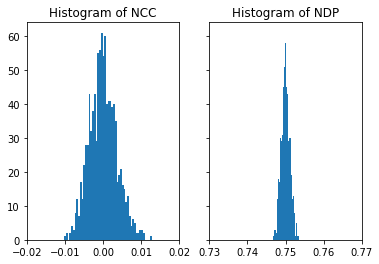

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(nc_vals, bins=50)
ax1.set_title('Histogram of NCC')
ax1.set_xlim([-0.02, 0.02])
ax2.hist(nd_vals, bins=50)
ax2.set_title('Histogram of NDP')
ax2.set_xlim([-0.02+0.75, 0.02+0.75])
plt.show()

If we use a symmetrical range around 0.0 for the image entries, we effectively calculate the NCC, and thus NDP=NCC in this limit:

In [44]:
# this is for vectors with entries -1...1
nc_vals, nd_vals = compare_random_images(nruns, offset=-1.0, scale=2.0)

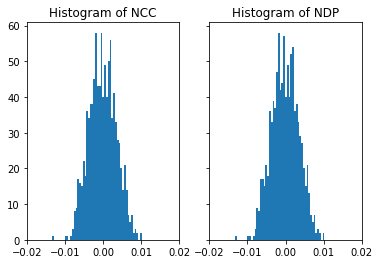

In [45]:
# now we have the same histogram for both (i.e. ncc=ndp in this limit, since we have the mean=0.0)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(nc_vals, bins=50)
ax1.set_title('Histogram of NCC')
ax1.set_xlim([-0.02, 0.02])
ax2.hist(nd_vals, bins=50)
ax2.set_title('Histogram of NDP')
ax2.set_xlim([-0.02, 0.02])
plt.show()

In [46]:
# this is for vectors with entries -0.5...0.5
nc_vals, nd_vals = compare_random_images(nruns, offset=-0.5, scale=1.0)

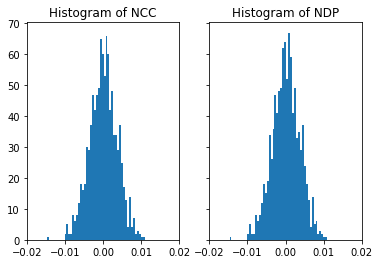

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(nc_vals, bins=50)
ax1.set_title('Histogram of NCC')
ax1.set_xlim([-0.02, 0.02])
ax2.hist(nd_vals, bins=50)
ax2.set_title('Histogram of NDP')
ax2.set_xlim([-0.02, 0.02])
plt.show()

## Appendix

### numpy.corrcoef

We can also use numpy directly to get the NCCs for all combinations of several data sets
In the returned matrix of [numpy.corrcoef](https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html), the i-j element gives the NCC of dataset i with dataset j.

For an example, see also: https://stackoverflow.com/questions/3425439/why-does-corrcoef-return-a-matrix

In [48]:
datasets=[U_true,U_exp,V_true,V_exp]
ncc_matrix=np.corrcoef(datasets)
print(ncc_matrix)

[[ 1.          0.67928576  1.          0.76780393]
 [ 0.67928576  1.          0.67928576  0.60826352]
 [ 1.          0.67928576  1.          0.76780393]
 [ 0.76780393  0.60826352  0.76780393  1.        ]]


### Cholesky decomposition for correlated data simulation

https://math.stackexchange.com/questions/163470/generating-correlated-random-numbers-why-does-cholesky-decomposition-work

https://stats.stackexchange.com/questions/160054/how-to-use-the-cholesky-decomposition-or-an-alternative-for-correlated-data-si

In [49]:
import numpy as np
np.random.seed(1234)

no_obs = 10000            # Number of observations 
means = [1, 2, 3]         # Mean values of each column
no_cols = 3               # Number of columns

sds = [1, 2, 3]           # SD of each column
sd = np.diag(sds)         # SD in a diagonal matrix for later operations

observations = np.random.normal(0, 1, (no_cols, no_obs)) # Rd draws N(0,1) in [3 x 1,000]

cor_matrix = np.array([[1.0, 0.6, 0.9],
                       [0.6, 1.0, 0.5],
                       [0.9, 0.5, 1.0]])          # The correlation matrix [3 x 3]

cov_matrix = np.dot(sd, np.dot(cor_matrix, sd))   # The covariance matrix

Chol = np.linalg.cholesky(cov_matrix)             # Cholesky decomposition

#array([[ 1.        ,  0.        ,  0.        ],
#       [ 1.2       ,  1.6       ,  0.        ],
#       [ 2.7       , -0.15      ,  1.29903811]])

sam_eq_mean = Chol.dot(observations)             # Generating random MVN (0, cov_matrix)

s = sam_eq_mean.transpose() + means               # Adding the means column wise
samples = s.transpose()                           # Transposing back

print(np.corrcoef(samples))                       # Checking correlation consistency.

# reference output (random, use seed 1234)
#[[ 1.          0.59714623  0.89991841]
# [ 0.59714623  1.          0.49739338]
# [ 0.89991841  0.49739338  1.        ]]

[[ 1.          0.59714623  0.89991841]
 [ 0.59714623  1.          0.49739338]
 [ 0.89991841  0.49739338  1.        ]]


## Equivalence of FFT convolution and Normalized Cross Correlation Coefficient

principle: the signals must be periodic and thus only shifted in the "unit cell", i.e. sine or cosine must be cut at exactly the same places and padded with zeros

See also:
https://stackoverflow.com/questions/46457866/how-do-i-scale-an-fft-based-cross-correlation-such-that-its-peak-is-equal-to-pea

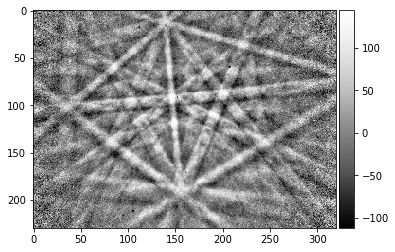

(230, 320)

In [50]:
kiku_exp = imread("../data/patterns/Ni_Example3.png")
kiku_exp = kiku_exp - np.nanmean(kiku_exp)
plot_image(kiku_exp)
motif_h, motif_w = kiku_exp.shape 
kiku_exp.shape

For comparison, we load a simulated pattern. To take into account that we do not know  the absolute scale of experiment relative to the theory, we scale the theory by an arbitrary factor. 

Because we subtract the mean from the experiment and the simulation, we now have now two signals, which vary around a mean value of zero. 

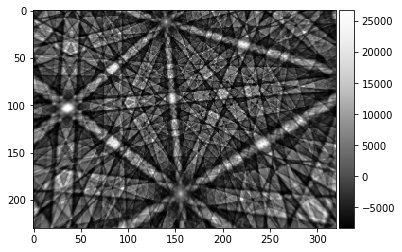

(230, 320)

In [52]:
kiku_sim = 137.314 * (imread("../data/patterns/Ni_Example3_sim.png", asgray=True)[:,:,0]).astype(np.float32)
kiku_sim = kiku_sim - np.nanmean(kiku_sim)
plot_image(kiku_sim)
kiku_sim.shape

For reference, we calculate the Pearson normalized cross correlation coefficient, like defined at the top of the notebook:

In [53]:
r_ncc = ncc(kiku_exp, kiku_sim)
print(r_ncc)

0.540148580213


In [54]:
def fill_fft_cell(image, shift, cell_size=512):
    cell = np.zeros((cell_size, cell_size), dtype=np.float32)
    shift_row = shift[0] % cell_size
    shift_col = shift[1] % cell_size
    for r in range(shift_row, shift_row + image.shape[0]):
        for c in range(shift_col, shift_col + image.shape[1]):
            cell[r % cell_size, c % cell_size] = image[r-shift_row, c-shift_col]

    return cell

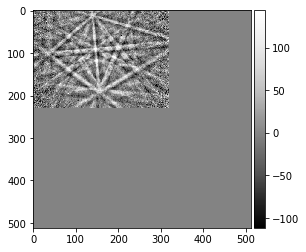

In [55]:
reference = fill_fft_cell(kiku_exp, [0, 0])
plot_image(reference)

known shift of simulation (row, col):  51 397


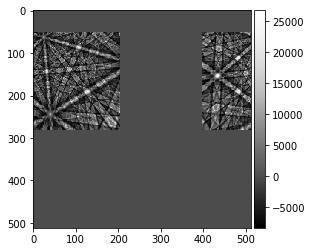

In [56]:
# note that this works also for "backfolding" images! FFT periodicity!
shift_row = np.random.randint(0, 512) 
shift_col = np.random.randint(0, 512)
print("known shift of simulation (row, col): ", shift_row, shift_col)

shifted_sim = fill_fft_cell(kiku_sim, [shift_row, shift_col])
plot_image(shifted_sim)

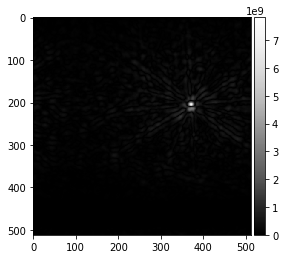

position of maximum ( rows, cols, [0,0] at center, fftshift):  51 397
xc fft max 7.8204e+09


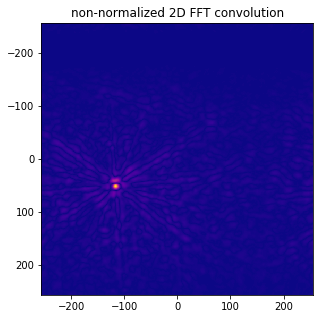

In [57]:
image1 = reference
image2 = shifted_sim
M, N = image1.shape

# fftshift puts the zero frequencies to the middle of the array
xc_fft = np.fft.fftshift(np.abs( np.fft.ifft2( np.fft.fft2(image1) * np.fft.fft2(image2).conjugate()) ))
plot_image(xc_fft)

f, ax = plt.subplots(figsize=(5, 5))
ax.imshow(np.flipud(np.fliplr(xc_fft)), cmap='plasma', 
          extent=(-N // 2, +N // 2, M // 2, -M // 2))
ax.set_title('non-normalized 2D FFT convolution');

max_xcfft = np.unravel_index(np.argmax(xc_fft, axis=None), xc_fft.shape)
row_max = (256 - max_xcfft[0]) % 512
col_max = (256 - max_xcfft[1]) % 512
print ('position of maximum ( rows, cols, [0,0] at center, fftshift): ', row_max, col_max)
print ('xc fft max', np.max(xc_fft)) 

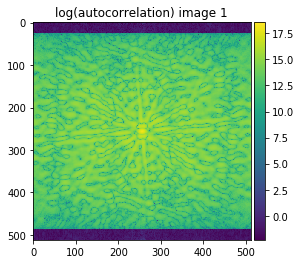

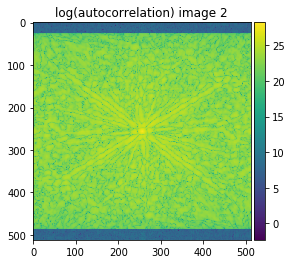

In [58]:
autocorrelation_1 = np.fft.fftshift(np.abs(np.fft.ifft2(np.fft.fftn(image1)*np.fft.fft2(image1).conjugate())))
autocorrelation_2 = np.fft.fftshift(np.abs(np.fft.ifft2(np.fft.fftn(image2)*np.fft.fft2(image2).conjugate())))
plot_image(np.log(autocorrelation_1+0.1), title='log(autocorrelation) image 1', cmap='viridis')
plot_image(np.log(autocorrelation_2+0.1), title='log(autocorrelation) image 2', cmap='viridis')

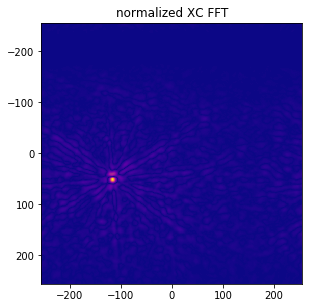

In [59]:
intensity_1 = np.max(autocorrelation_1)
intensity_2 = np.max(autocorrelation_2)
xc_denom = np.sqrt(intensity_1)* np.sqrt(intensity_2)

xc_normalized = xc_fft/xc_denom

f, ax = plt.subplots(figsize=(4.8, 4.8))
# set extent to have axes with shift value (0,0) at center and shifting corresponding visually to images
# (only ++ quadrant is used for the known shift)
ax.imshow(np.flipud(np.fliplr(xc_normalized)), cmap='plasma',
          extent=(-N // 2, N // 2, M // 2, -M // 2))
ax.set_title('normalized XC FFT');

We can now find the position of the maximum and the corresponding value of xc_normalied, which should correspond to the cross correlation coefficient reference value r_ncc as calculated above:

In [60]:
# indices of maxmimum in 2D
max_rc = np.unravel_index(np.argmax(xc_normalized, axis=None), xc_normalized.shape)
# maximum value shoould be at theoretical shift vector
r_fft = np.max(xc_normalized)


print('Compare results (should be equal):\n')
print('known shift vector: ', shift_row, shift_col)

print('position of found r_fft maximum: ', (256 - max_rc[0]) % 512 , (256 - max_rc[1]) % 512)
print('r_fft: ', r_fft) 
print('r_ncc: ', r_ncc) 

# throw error if not equal up to 6 decimals
np.testing.assert_almost_equal(r_fft, r_ncc, 6)

Compare results (should be equal):

known shift vector:  51 397
position of found r_fft maximum:  51 397
r_fft:  0.540149
r_ncc:  0.540148580213


We have thus shown how to obtain the same cross-correlation coefficient as r_ncc by (a) normalization (mean=0, stddev=1.0) of the input images and then padding by zeroes inside a common 2D array size, and (b) the suitable scaling of the FFT by the maximum of the autocorrelations of both images (i.e. the energy in both images).
This demonstrates the intrinsic similarity of r_fft (determined by FFT) and r_ncc (determined by pixel-wise formula for the normalized cross-correlation coeffcient).

### Subpixel resolution

http://scikit-image.org/docs/dev/auto_examples/transform/plot_register_translation.html


Known offset (y, x): (12.4, 3.32)
Detected pixel offset (y, x): [-12.  -3.]


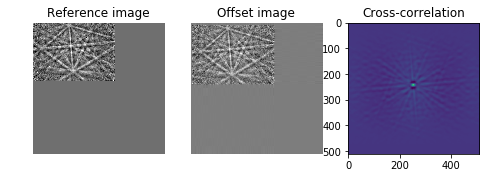

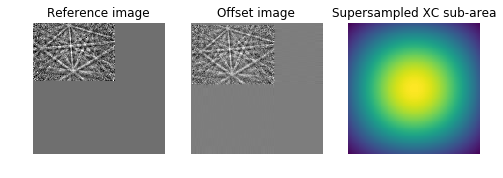

Detected subpixel offset (y, x): [-12.4   -3.32]


In [61]:
from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift

image = image1
shift = (12.4, 3.32)
# The shift corresponds to the pixel offset relative to the reference image
offset_image = fourier_shift(np.fft.fft2(image), shift)
offset_image = np.fft.ifft2(offset_image)
print("Known offset (y, x): {}".format(shift))

# pixel precision first
shift, error, diffphase = register_translation(image, offset_image)
print("Detected pixel offset (y, x): {}".format(shift))

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
#ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()


# subpixel precision
shift, error, diffphase = register_translation(image, offset_image, 200)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print("Detected subpixel offset (y, x): {}".format(shift))